<a href="https://colab.research.google.com/github/DJCordhose/ml-resources/blob/main/notebooks/jax/intro-jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JAX Intro
* https://www.youtube.com/watch?v=WdTeDXsOSj4
* https://jax.readthedocs.io/en/latest/
* https://github.com/google/jax

In [1]:
#@title
import numpy as np
np.random.seed(42)

n = 50
m = 1
b = 2

# noise_level = 1
noise_level = .5
noise = np.random.normal(0, noise_level, n)

title = 'Historic data on beer consumption as a function of temperature'
x_label = 'Temperature * 10'
y_label = 'Halbes per Guest'

# sort is not necessary, but makes x easier to understand
x = np.sort(np.random.uniform(1, 4, n))
# x = np.sort(np.random.uniform(10, 40, n))

y = m*x+b + noise

# Challenge
* we run a beer garden
* we need to buy a sufficient amount of beer at the beginning of a week
* how much beer will people drink per guest next week?
* our beer garden is very popular and full anyway
* but we know that temperature is a strong indicator for consumption per guest

## Predict beer consumption as a function of temperature

# Prediction using hand written linear model

we *assume* that there is a linear correlation between the temparature and number of drinks per guest

## Our model: linear

### ```y = w*x + b```

* `w` is the slope 
* `b` is the y-intercept


In [2]:
import jax.tools.colab_tpu
# most likely slower on a tiny problem like this
# jax.tools.colab_tpu.setup_tpu()

In [3]:
import jax.numpy as jnp

X = jnp.expand_dims(x, axis=1)
Y = jnp.array(y)

# global model weights
params = {
    'w': jnp.array([.5]),
    'b': 0.
}

def predict(params, X):
    return X@params['w'] + params['b']

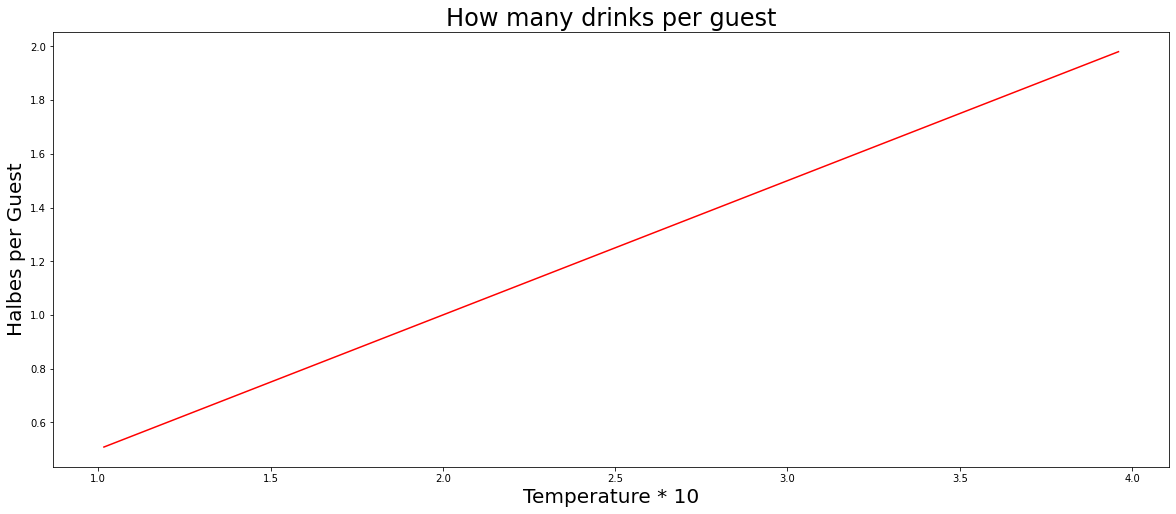

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

figsize_3d = (20, 10)

y_pred = predict(params, X)
plt.plot(x, y_pred, color='r');
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title("How many drinks per guest");

# How do we know if our model is good?

## Thankfully we have historic data

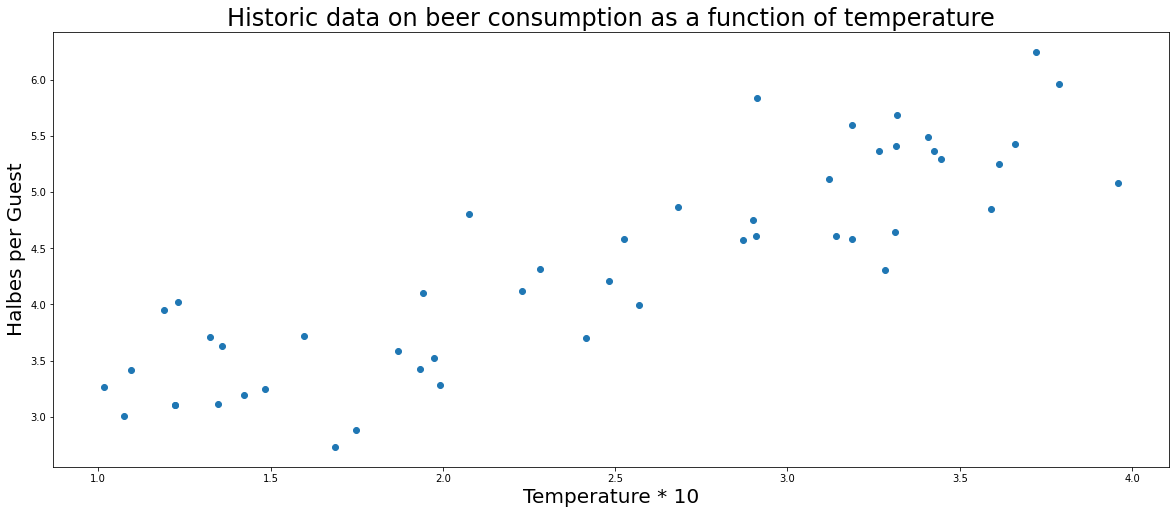

In [5]:
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)

plt.scatter(x, y);

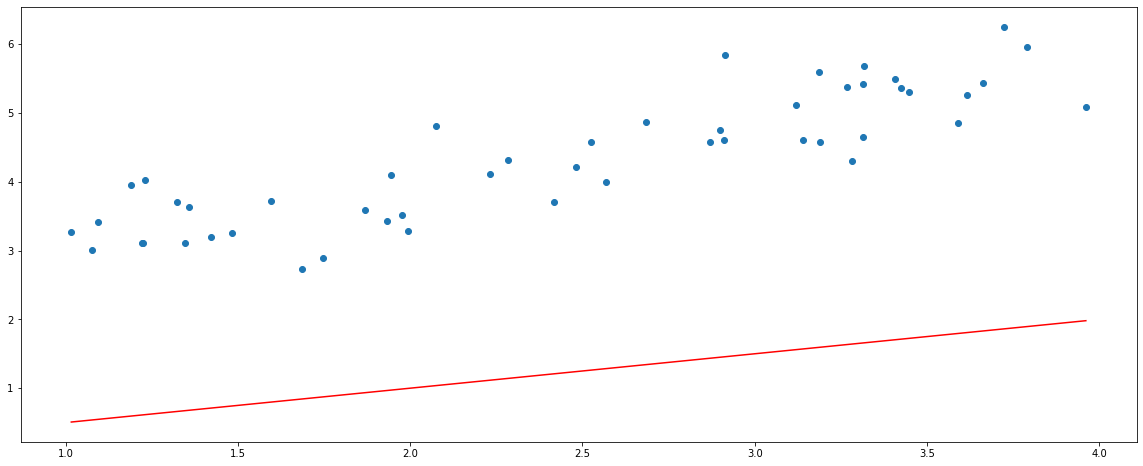

In [6]:
plt.plot(x, y_pred, color='r');
# plt.scatter(x, y_pred, color='r')
plt.scatter(x, y);

# Ok, this looks off, but how off?
## Mean Squared Error

emphasizes larger errors

$MSE = {\frac {1}{n}}\sum _{i=1}^{n}(Y_{i}-{\hat {Y_{i}}})^{2}$


https://en.wikipedia.org/wiki/Mean_squared_error

In [7]:
def loss_fn(params, X, y):
    y_pred = predict(params, X)
    err = y_pred - y
    return jnp.mean(jnp.square(err))  # mse

In [8]:
mse_loss = loss_fn(params, X, y)
print(mse_loss)

10.011332


In [9]:
from jax import jit

# compile to run fast
jit_loss_fn = jit(loss_fn)
jit_loss_fn(params, X, y)

DeviceArray(10.011332, dtype=float32)

# We can use that metric of error to improve our model

DeviceArray(3.7753375, dtype=float32)

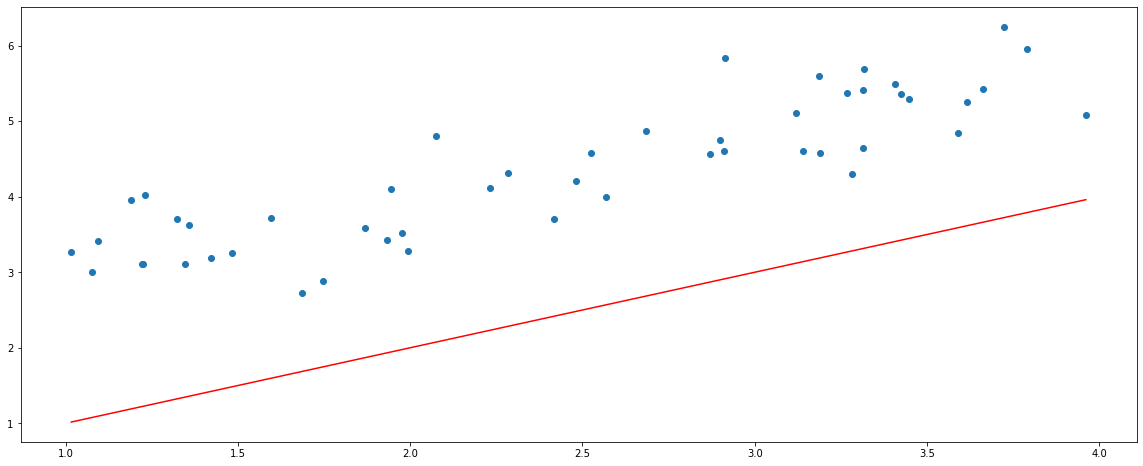

In [10]:
params['w'] = jnp.array([1.])
y_pred = predict(params, X)
plt.plot(x, y_pred, color='r');
# plt.scatter(x, y_pred, color='r')
plt.scatter(x, y);
loss_fn(params, X, y)

# Why do something by hand in an hour that you can spend a week automating?

CPU times: user 19.9 s, sys: 259 ms, total: 20.2 s
Wall time: 23.7 s


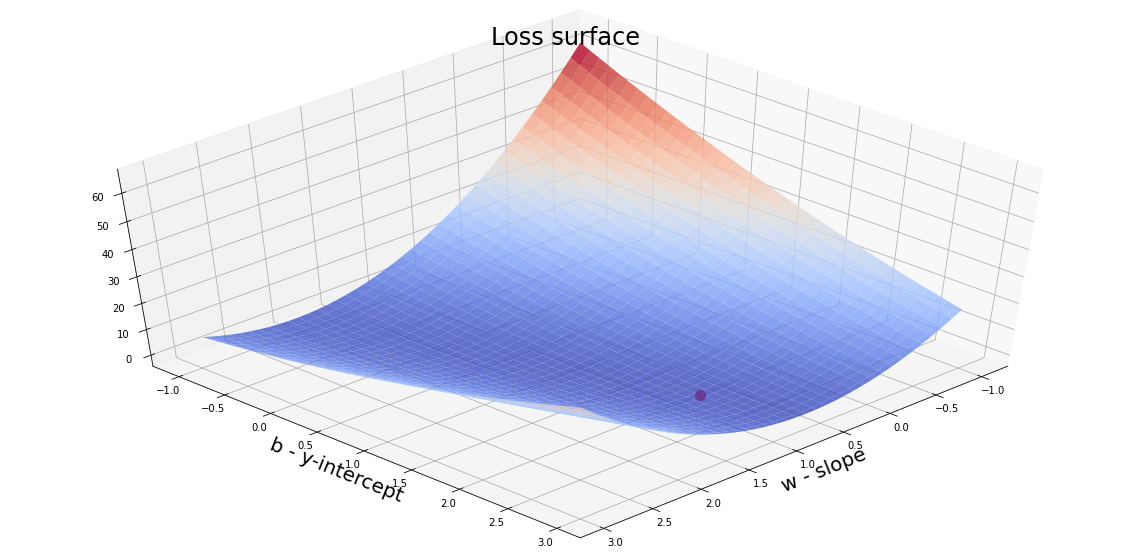

In [11]:
%%time

import numpy as np

step = 0.05
w_space = jnp.arange(-1, 3, step)
b_space = jnp.arange(-1, 3, step)

sample_size = len(w_space)
losses = np.zeros((sample_size, sample_size))

min_loss = float('inf')
min_params = None

for w_idx in range(sample_size):
  for b_idx in range(sample_size):
    w = w_space[w_idx]
    b = b_space[b_idx]
    candidate_params = {
        'w': jnp.array([w]),
        'b': b
    }
    # loss = loss_fn(candidate_params, X, y)
    loss = jit_loss_fn(candidate_params, X, y)
    
    if loss < min_loss:
      min_loss = loss
      min_params = candidate_params
    # the order seems weird, but aparently this is what the 3d plot expects  
    losses[b_idx, w_idx] = loss

# min_loss, min_params

# https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=figsize_3d)
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Loss surface')

M, B = np.meshgrid(w_space, b_space)

# ax.plot_wireframe(W, B, losses)
surf = ax.plot_surface(M, B, losses, cmap=cm.coolwarm, 
                      #  linewidth=0, 
                       alpha=0.8,
                      #  antialiased=False
                       )
# fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_xlabel('w - slope')
ax.set_ylabel('b - y-intercept')

ax.scatter(min_params['w'], min_params['b'], min_loss, s=100, color='r')

# https://en.wikipedia.org/wiki/Azimuth
# ax.view_init(elev=30, azim=-60); # default
ax.view_init(elev=50, azim=45);
# ax.view_init(elev=15, azim=70);

min_loss, min_params

In [12]:
min_loss, min_params

(DeviceArray(0.20625123, dtype=float32),
 {'b': DeviceArray(2.1500008, dtype=float32),
  'w': DeviceArray([0.90000045], dtype=float32)})

# Brute force does work for this example
## But time complexity is bad and impractical for larger problems

DeviceArray(0.20625128, dtype=float32)

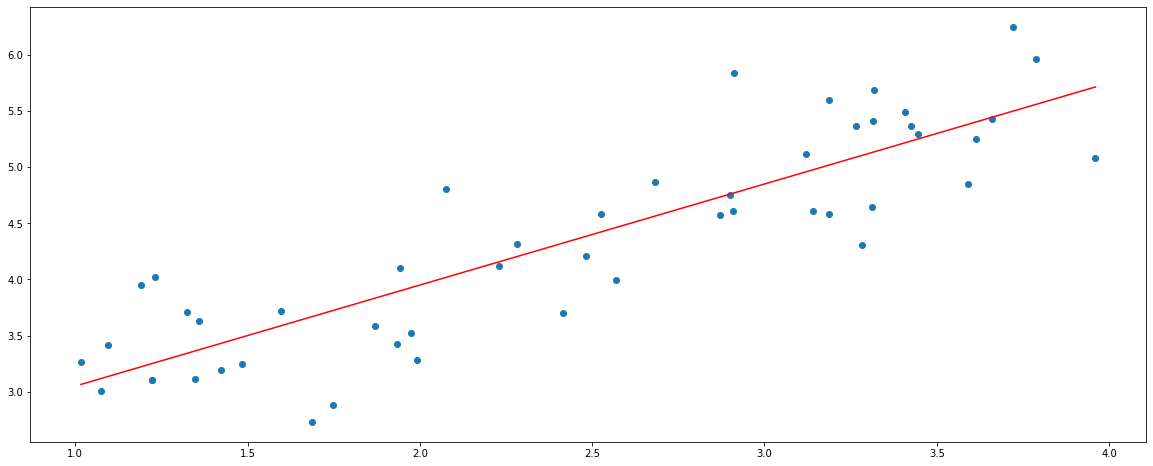

In [13]:
y_pred = predict(min_params, X)
plt.plot(x, y_pred, color='r');
# plt.scatter(x, y_pred, color='r')
plt.scatter(x, y);
loss_fn(min_params, X, y)

# Why not slide down the error function until we reach a minumum
## works in arbitray many dimensions and all sizes

In [14]:
from jax import value_and_grad, grad

def square(x):
  return x ** 2

# going down requires the gradient, but jax has you covered here
grad_square = value_and_grad(square)
print(grad_square(3.0))

(DeviceArray(9., dtype=float32, weak_type=True), DeviceArray(6., dtype=float32, weak_type=True))


## This is an iterative process
typical parameters
* how many iterations: epochs
* how fast do we slide down: learning rate

In [15]:
%%time

epochs = 200
learning_rate = 0.1

losses = []
ws = []
bs = []
dws = []
dbs = []

# initial model weights
params = {
    'w': jnp.array([0.]),
    'b': 0.
}

# this is a bit time consuming, compilation will help
loss_value_and_grad = jit(value_and_grad(loss_fn))
# loss_value_and_grad = value_and_grad(loss_fn)

# iteration
for _ in range(epochs):
    loss, grads = loss_value_and_grad(params, X, Y)
    losses.append(loss)
    # print(loss)

    dw = grads['w']
    db = grads['b']
    dws.append(dw)
    dbs.append(db)
    # print(grads)

    ws.append(params['w'])
    bs.append(params['b'])
    # print(params)
    
    params['w'] -= learning_rate * dw
    params['b'] -= learning_rate * db

losses[-1], params   

CPU times: user 135 ms, sys: 988 µs, total: 136 ms
Wall time: 137 ms


In [16]:
losses[-1], params

(DeviceArray(0.20598896, dtype=float32),
 {'b': DeviceArray(2.1030564, dtype=float32, weak_type=True),
  'w': DeviceArray([0.9108024], dtype=float32)})

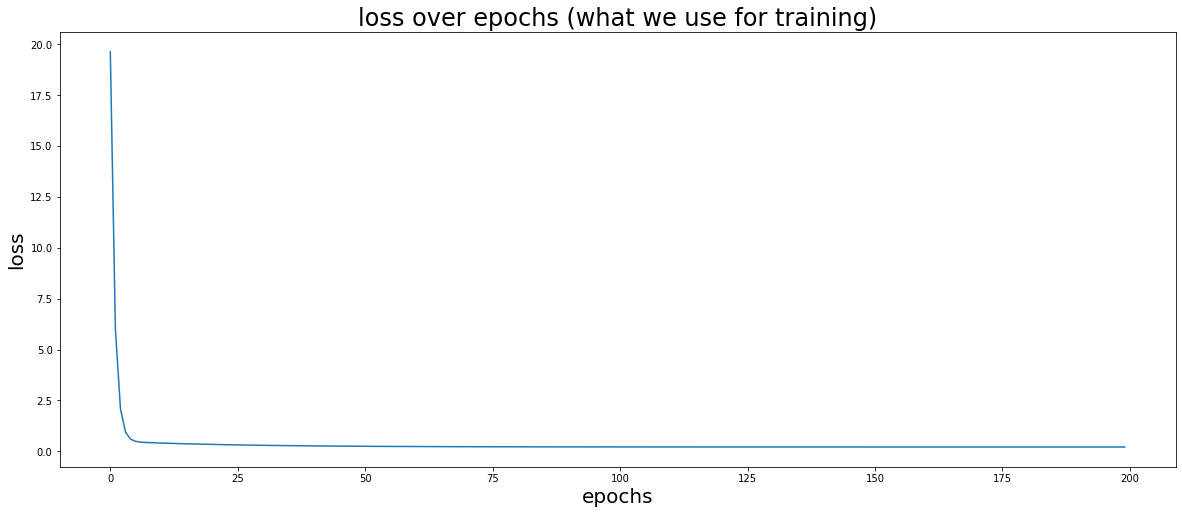

In [17]:
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss over epochs (what we use for training)')

# plt.yscale('log')

plt.plot(losses);

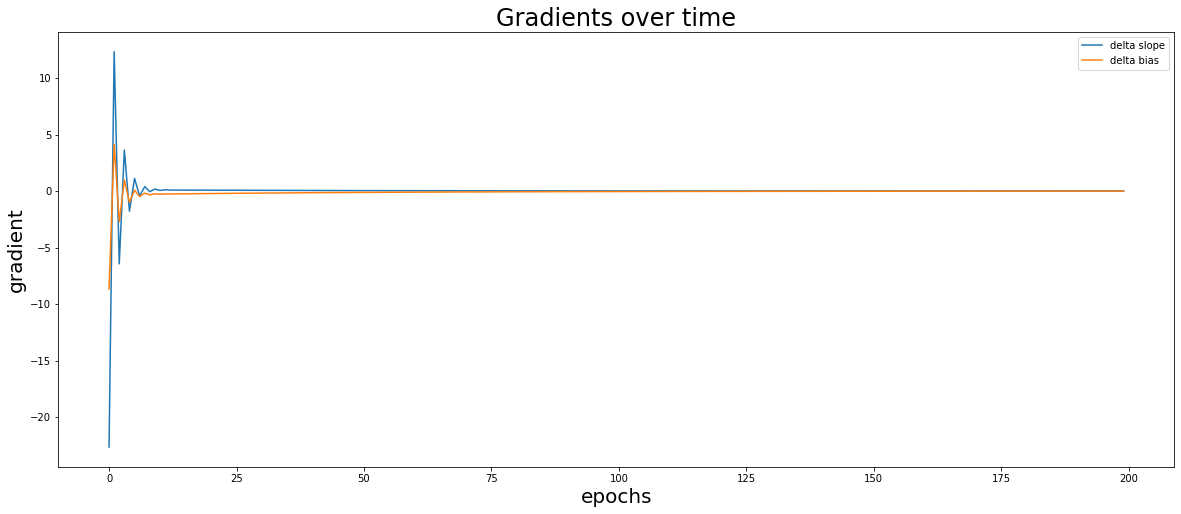

In [18]:
plt.xlabel('epochs')
plt.ylabel('gradient')
plt.title('Gradients over time')

# plt.yscale('log')

plt.plot(dws);
plt.plot(dbs);
plt.legend(['delta slope', 'delta bias']);

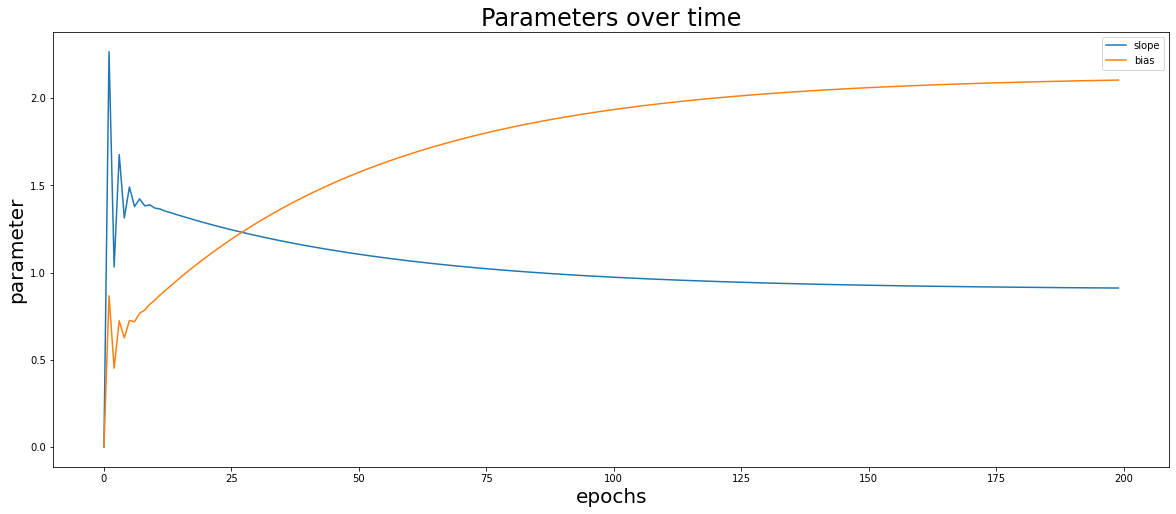

In [19]:
plt.xlabel('epochs')
plt.ylabel('parameter')
plt.title('Parameters over time')

# plt.yscale('log')

plt.plot(ws);
plt.plot(bs);
plt.legend(['slope', 'bias']);

DeviceArray(0.20598617, dtype=float32)

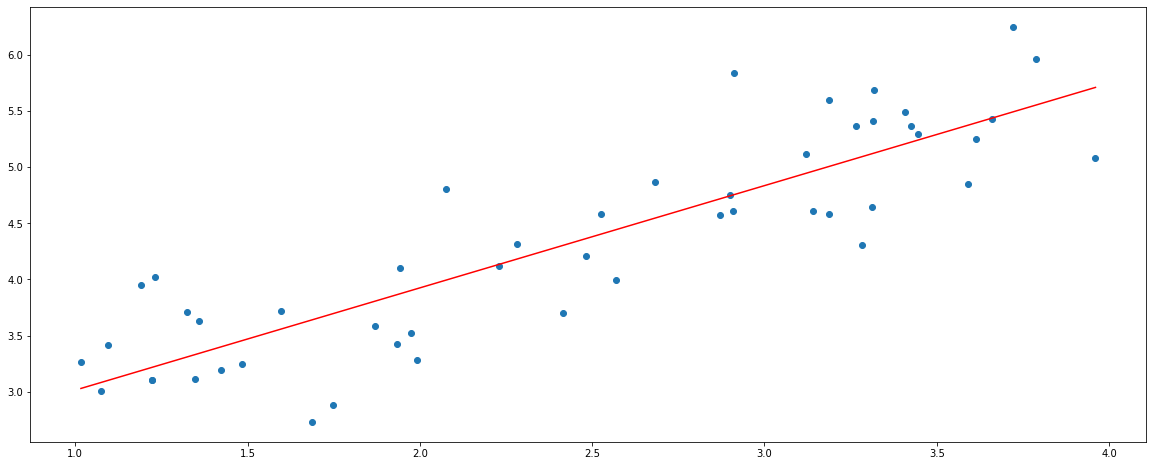

In [20]:
y_pred = predict(params, X)
plt.plot(x, y_pred, color='r');
# plt.scatter(x, y_pred, color='r')
plt.scatter(x, y);
loss_fn(params, X, y)

# Great visual resources for understanding learning rate:

* https://twitter.com/matthen2/status/1520427516997025792
* https://www.alanzucconi.com/2017/04/10/gradient-descent/


# Summary: we just derived the Backpropagation algorithm
## The core of how a neural network learns

_In a nutshell:_
1. Predict: Let the network make a prediction 
1. Calculate the loss: how accurate was the predition
1. Partial Derivations: find out in which direction to change all parameters to bring down the loss
1. Optimizer: Make changes to parameters based on learning rate and other parameters
1. Rinse and Repeat